This project has two parts. In the first part, you will run a regression, and identify and remove the 10% of points that have the largest residual errors. Then you’ll remove those outliers from the dataset and refit the regression.

In the second part, you will get acquainted with some of the outliers in the Enron finance data, and learn if/how to remove them.

In the mini-project for the regressions lesson, you used a regression to predict the bonuses for Enron employees. As you saw, even a single outlier can make a big difference on the regression result. There was something we didn’t tell you, though, which was that the dataset we had you use in that project had already been cleaned of some significant outliers. Identifying and cleaning away outliers is something you should always think about when looking at a dataset for the first time, and now you’ll get some hands-on experience with the Enron data.



In [9]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
from pprint import pprint
import os
os.chdir('C:\Users\Administrator\Desktop')
%matplotlib inline


In [3]:
"""
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm
    n--no. of key-value pairs in dictonary
    k--no. of features being extracted
    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person
    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for
    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:
    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)
    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)

In [4]:
def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)
        return targets and features as separate lists
        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

In [7]:
### read in data dictionary, convert to numpy array
data_dict = pickle.load( open("final_project_dataset_modified.pkl", "r") )
features = ["salary", "bonus"]
data_dict.pop('TOTAL',0) # Added after finding the outlier
data = featureFormat(data_dict, features)

You can find in outliers/enron_outliers, which reads in the data (in dictionary form) and converts it into a sklearn-ready numpy array. Since there are two features being extracted from the dictionary (“salary” and “bonus”), the resulting numpy array will be of dimension N x 2, where N is the number of data points and 2 is the number of features. This is perfect input for a scatterplot; we’ll use the matplotlib.pyplot module to make that plot.

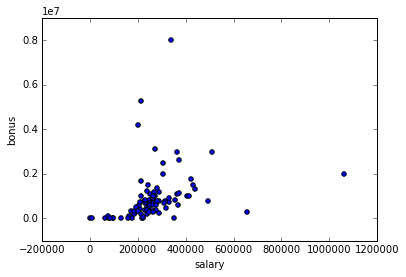

In [12]:
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()


There’s one outlier that should pop out to you immediately. Now the question is to identify the source.
What’s the name of the dictionary key of this data point?

In [16]:
for key, value in data_dict.items():
    if value['bonus'] == data.max():
        print key

LAVORATO JOHN J


In [17]:
biggest = 0
for key, value in data_dict.items():
    if value['bonus'] > biggest:
        biggest = value['bonus']
        print key        

METTS MARK
BAXTER JOHN C
CORDES WILLIAM R


In outlierCleaner, you will find the skeleton for a function called outlierCleaner() that you will fill in with a cleaning algorithm. It takes three arguments: predictions is a list of predicted targets that come from your regression, ages is the list of ages in the training set, and net_worths is the actual value of the net worths in the training set. There should be 90 elements in each of these lists (because the training set has 90 points in it). Your job is to return a list called cleaned_data that has only 81 elements in it, which are the 81 training points where the predictions and the actual values (net_worths) have the smallest errors (90 * 0.9 = 81). The format of cleaned_data should be a list of tuples, where each tuple has the form (age, net_worth, error). 


In [18]:
def outlierCleaner(predictions, ages, net_worths):
    """
        clean away the 10% of points that have the largest
        residual errors (different between the prediction
        and the actual net worth)
        return a list of tuples named cleaned_data where 
        each tuple is of the form (age, net_worth, error)
    """
    
    cleaned_data = []
    
    for i in range(len(predictions)):
        residuals = abs(net_worths[i] - predictions[i])
        cleaned_data.append((ages[i], net_worths[i], residuals))
    
    cleaned_data.sort(key=lambda tup: tup[2])
    cleaned_data = cleaned_data[:int(len(predictions)*0.9)]
    
    return cleaned_data


In [19]:
### load up some practice data with outliers in it
ages = pickle.load( open("practice_outliers_ages.pkl", "r") )
net_worths = pickle.load( open("practice_outliers_net_worths.pkl", "r") )

In [21]:
### ages and net_worths need to be reshaped into 2D numpy arrays
### second argument of reshape command is a tuple of integers: (n_rows, n_columns)
### by convention, n_rows is the number of data points
### and n_columns is the number of features
ages       = np.reshape( np.array(ages), (len(ages), 1))
net_worths = np.reshape( np.array(net_worths), (len(net_worths), 1))
from sklearn.cross_validation import train_test_split
ages_train, ages_test, net_worths_train, net_worths_test = train_test_split(ages, net_worths, test_size=0.1, random_state=42)


What is the score you get when using your regression to make predictions with the test data?

In [22]:
### fill in a regression here!  Name the regression object reg so that
### the plotting code below works, and you can see what your regression looks like
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(ages_train,net_worths_train)

print "Score: ", reg.score( ages_test, net_worths_test )


Score:  0.878262478835


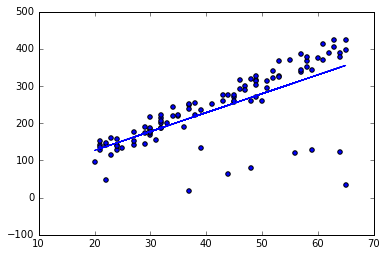

In [23]:
try:
    plt.plot(ages, reg.predict(ages), color="blue")
except NameError:
    pass
plt.scatter(ages, net_worths)
plt.show()

Once this cleaning function is working, you should see the regression result changes. What is the new slope and score when you use the regression to make predictions on the test set?

In [24]:
### identify and remove the most outlier-y points
cleaned_data = []
try:
    predictions = reg.predict(ages_train)
    cleaned_data = outlierCleaner( predictions, ages_train, net_worths_train )
except NameError:
    print "your regression object doesn't exist, or isn't name reg"
    print "can't make predictions to use in identifying outliers"

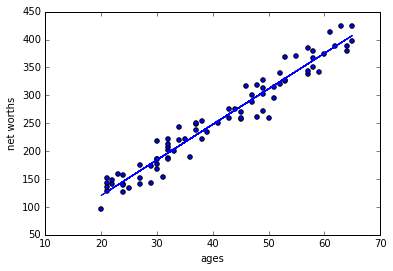

Score:  0.983189455686
Slope:  [[ 6.36859481]]


In [27]:
### only run this code if cleaned_data is returning data
if len(cleaned_data) > 0:
    ages, net_worths, errors = zip(*cleaned_data)
    ages       = np.reshape( np.array(ages), (len(ages), 1))
    net_worths = np.reshape( np.array(net_worths), (len(net_worths), 1))

    ### refit your cleaned data!
    try:
        reg.fit(ages, net_worths)
        plt.plot(ages, reg.predict(ages), color="blue")
    except NameError:
        print "you don't seem to have regression imported/created,"
        print "   or else your regression object isn't named reg"
        print "   either way, only draw the scatter plot of the cleaned data"
    plt.scatter(ages, net_worths)
    plt.xlabel("ages")
    plt.ylabel("net worths")
    plt.show()
    print "Score: ", reg.score( ages_test, net_worths_test )
    print "Slope: ", reg.coef_
    
else:
    print "outlierCleaner() is returning an empty list, no refitting to be done"